# House Prices: Advanced Regression Techniques

### Import Required Libraries

In [1]:
# Reading / Writing Files & Encoding
import numpy as np
import pandas as pd

# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Sampling
from imblearn.over_sampling import SMOTE

# Ensembles & Functions
from vecstack import stacking
from sklearn.svm import LinearSVR as svr
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Accuracy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_log_error

# Miscellaneous
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Load in Data, Create Dataframes and Perform Basic Cleaning & Operations

In [2]:
# Dropping columns with less than ~80% of data available ("thresh=1160")
train_df = pd.read_csv("data/project_data/train.csv").dropna(axis=1,thresh=1160)
y = train_df['SalePrice']
train_df = train_df.drop(['SalePrice'],axis=1)
test_df = pd.read_csv("data/project_data/test.csv").dropna(axis=1,thresh=1160)
concat_df = pd.concat([train_df,test_df],keys=[0,1])
concat_df

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
0 0        1          60       RL         65.0     8450   Pave      Reg   
  1        2          20       RL         80.0     9600   Pave      Reg   
  2        3          60       RL         68.0    11250   Pave      IR1   
  3        4          70       RL         60.0     9550   Pave      IR1   
  4        5          60       RL         84.0    14260   Pave      IR1   
...      ...         ...      ...          ...      ...    ...      ...   
1 1454  2915         160       RM         21.0     1936   Pave      Reg   
  1455  2916         160       RM         21.0     1894   Pave      Reg   
  1456  2917          20       RL        160.0    20000   Pave      Reg   
  1457  2918          85       RL         62.0    10441   Pave      Reg   
  1458  2919          60       RL         74.0     9627   Pave      Reg   

       LandContour Utilities LotConfig  ... OpenPorchSF EnclosedPorch  \
0 0            Lvl    AllPub    Inside  ...          61             0   
  1            Lvl    AllPub       FR2  ...           0             0   
  2            Lvl    AllPub    Inside  ...          42             0   
  3            Lvl    AllPub    Corner  ...          35           272   
  4            Lvl    AllPub       FR2  ...          84             0   
...            ...       ...       ...  ...         ...           ...   
1 1454         Lvl    AllPub    Inside  ...           0             0   
  1455         Lvl    AllPub    Inside  ...          24             0   
  1456         Lvl    AllPub    Inside  ...           0             0   
  1457         Lvl    AllPub    Inside  ...          32             0   
  1458         Lvl    AllPub    Inside  ...          48             0   

       3SsnPorch ScreenPorch PoolArea MiscVal  MoSold  YrSold  SaleType  \
0 0            0           0        0       0       2    2008        WD   
  1            0           0        0       0       5    2007        WD   
  2            0           0        0       0       9    2008        WD   
  3            0           0        0       0       2    2006        WD   
  4            0           0        0       0      12    2008        WD   
...          ...         ...      ...     ...     ...     ...       ...   
1 1454         0           0        0       0       6    2006        WD   
  1455         0           0        0       0       4    2006        WD   
  1456         0           0        0       0       9    2006        WD   
  1457         0           0        0     700       7    2006        WD   
  1458         0           0        0       0      11    2006        WD   

        SaleCondition  
0 0            Normal  
  1            Normal  
  2            Normal  
  3           Abnorml  
  4            Normal  
...               ...  
1 1454         Normal  
  1455        Abnorml  
  1456        Abnorml  
  1457         Normal  
  1458         Normal  

[2919 rows x 75 columns]

The data manipulation that still needs to take place is: i) removing the remaining n/a values and replacing them with the average value for that column; ii) perform encoding on categorical parameters; and iii) apply scaling due to the uneven nature of the data (significant outliers).

### Preprocessing Step One: Replacing NAN Values

In [3]:
columns = concat_df.keys()
encode_columns = []
scale_columns = []

In [4]:
# Appending Columns (by Datatype) into their respective bins. 
# Encoding will take place on data within the appropriate bin
for i in range(len(columns)):
    if type(concat_df[columns[i]][0][0]) != str:
        scale_columns.append(columns[i])
    else:
        encode_columns.append(columns[i])

In [5]:
# Replacing NAN Values in String Columns with 'Most Common'
for i in range(len(encode_columns)):
    concat_df[encode_columns[i]].fillna(Counter(concat_df[encode_columns[i]]).most_common(1)[0][0], inplace=True)

In [6]:
# Replacing NAN Values in Numeric Columns with 'Mean'
for i in range(len(scale_columns)):
    concat_df[scale_columns[i]].fillna((concat_df[scale_columns[i]].mean()), inplace=True)

### Preprocessing Step Two: Encoding Categorical Parameters

In [7]:
encoded_df = pd.get_dummies(concat_df, columns=encode_columns)
encoded_df

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0 0        1          60         65.0     8450            7            5   
  1        2          20         80.0     9600            6            8   
  2        3          60         68.0    11250            7            5   
  3        4          70         60.0     9550            7            5   
  4        5          60         84.0    14260            8            5   
...      ...         ...          ...      ...          ...          ...   
1 1454  2915         160         21.0     1936            4            7   
  1455  2916         160         21.0     1894            4            5   
  1456  2917          20        160.0    20000            5            7   
  1457  2918          85         62.0    10441            5            5   
  1458  2919          60         74.0     9627            7            5   

        YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLw  \
0 0          2003          2003       196.0       706.0  ...               0   
  1          1976          1976         0.0       978.0  ...               0   
  2          2001          2002       162.0       486.0  ...               0   
  3          1915          1970         0.0       216.0  ...               0   
  4          2000          2000       350.0       655.0  ...               0   
...           ...           ...         ...         ...  ...             ...   
1 1454       1970          1970         0.0         0.0  ...               0   
  1455       1970          1970         0.0       252.0  ...               0   
  1456       1960          1996         0.0      1224.0  ...               0   
  1457       1992          1992         0.0       337.0  ...               0   
  1458       1993          1994        94.0       758.0  ...               0   

        SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0 0                0             0            1                      0   
  1                0             0            1                      0   
  2                0             0            1                      0   
  3                0             0            1                      1   
  4                0             0            1                      0   
...              ...           ...          ...                    ...   
1 1454             0             0            1                      0   
  1455             0             0            1                      1   
  1456             0             0            1                      1   
  1457             0             0            1                      0   
  1458             0             0            1                      0   

        SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0 0                         0                     0                     0   
  1                         0                     0                     0   
  2                         0                     0                     0   
  3                         0                     0                     0   
  4                         0                     0                     0   
...                       ...                   ...                   ...   
1 1454                      0                     0                     0   
  1455                      0                     0                     0   
  1456                      0                     0                     0   
  1457                      0                     0                     0   
  1458                      0                     0                     0   

        SaleCondition_Normal  SaleCondition_Partial  
0 0                        1                      0  
  1                        1                      0  
  2                        1                      0  
  3                        0                      0  
  4                        1                      0 

### Preprocessing Step Three: Scaling Dataset

MinMaxScaler() is the most conventional scaling method available within the Sklearn Library. Machine Learning algorithms are most effective in scaled data with a gaussian distribution. This dataset, while containing a lot of outliers (as shown below), can still be improved even with basic MinMaxScaling. Other scalers, such as RobustScaler() should perform better on datasets with significant outliers, but after testing, MinMaxScaler() had the best results on this dataset.

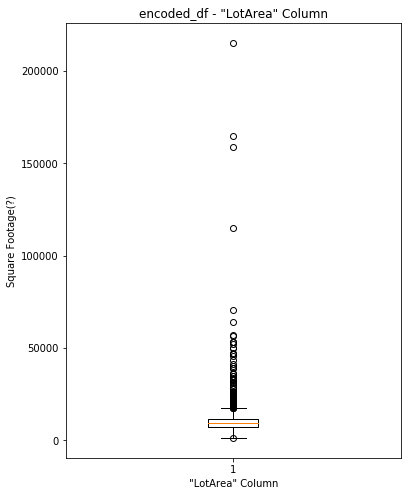

In [8]:
fig1, ax1 = plt.subplots(figsize=(6,8))
ax1.set_title('encoded_df - "LotArea" Column')
ax1.set_xlabel('"LotArea" Column')
ax1.set_ylabel('Square Footage(?)')
ax1.boxplot(encoded_df['LotArea'])
plt.show()

In [9]:
scaler = MinMaxScaler()

In [10]:
scale_columns = scale_columns[1:]
scaled_data = scaler.fit_transform(encoded_df[scale_columns])
scaled_df = pd.DataFrame(data=scaled_data, index = concat_df['Id'], columns=scale_columns)
encoded_df[scale_columns] = scaled_df[scale_columns].values

### Final Datames

In [11]:
train_df = encoded_df.xs(0)
train_df = train_df.set_index('Id')
X = train_df
test_df = encoded_df.xs(1)
test_df = test_df.set_index('Id')

In [12]:
train_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0,0,0,1,0,0,0,0,1,0
3,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0,0,0,1,0,0,0,0,1,0
4,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0,0,0,1,1,0,0,0,0,0
5,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,1,0
1457,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.106815,...,0,0,0,1,0,0,0,0,1,0
1458,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0,0,0,1,0,0,0,0,1,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [14]:
def RMSLE(y_test, X_test_prediction):
    print("=== ROOT MEAN SQUARED LOGARITHMIC ERROR ===")
    print(f"{mean_squared_log_error( y_test, X_test_prediction )}")

# 1. Decision Tree

In [15]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
decision_tree_prediction = decision_tree.predict(X_test)

In [16]:
RMSLE(y_test, decision_tree_prediction)

=== ROOT MEAN SQUARED LOGARITHMIC ERROR ===
0.040552193441637276


## 1.1 Decision Tree - Hyperparameter Tuning - RandomSearchCV

In [17]:
parameters = {
    'min_samples_split':[i*10 for i in range(1,10)],
    'criterion':['mse','mae'],
    'max_leaf_nodes':[i*10 for i in range(40,55)]
}

In [18]:
decision_tree_random = RandomizedSearchCV(decision_tree,parameters,n_iter=100,cv=5,n_jobs=-1,verbose=False)
decision_tree_random.fit(X_train, y_train)
decision_tree_random_params = decision_tree_random.best_params_
print(decision_tree_random_params)

{'min_samples_split': 40, 'max_leaf_nodes': 490, 'criterion': 'mae'}


In [19]:
decision_tree = DecisionTreeRegressor(**decision_tree_random_params)
decision_tree.fit(X_train, y_train)
decision_tree_prediction = decision_tree.predict(X_test)

In [20]:
RMSLE(y_test, decision_tree_prediction)

=== ROOT MEAN SQUARED LOGARITHMIC ERROR ===
0.03705333173365532


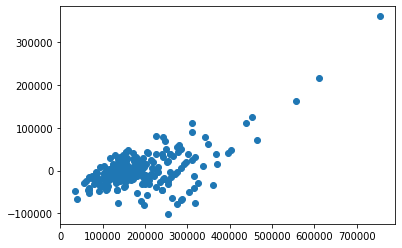

In [33]:
plt.scatter(y_test,y_test-decision_tree_prediction)

## 1.2 Decision Tree - Hyperparameter Tuning - GridSearchCV

In [ ]:
decision_tree_grid = GridSearchCV(decision_tree,parameters,n_jobs=-1,verbose=False)
decision_tree_grid.fit(X_train, y_train)
decision_tree_grid_params = decision_tree_grid.best_params_
print(decision_tree_grid_params)

In [ ]:
decision_tree = DecisionTreeRegressor(**decision_tree_grid_params)
decision_tree.fit(X_train, y_train)
decision_tree_prediction = decision_tree.predict(X_test)

In [ ]:
RMSLE(y_test, decision_tree_prediction)

## Kaggle Submission

In [ ]:
kaggle_df = pd.DataFrame()
kaggle_df['Id'] = test_df.index.to_list()
kaggle_df['SalePrice'] = DecisionTreeRegressor(**decision_tree_grid_params).fit(X_train,y_train).predict(test_df)
kaggle_df = kaggle_df.set_index(['Id'])
kaggle_df.to_csv("data/project_submissions/Decision_Tree_Kaggle_Submission.csv")

# 2. Random Forest

In [ ]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
random_forest_prediction = random_forest.predict(X_test)

In [ ]:
RMSLE(y_test, random_forest_prediction)

## 2.1 Random Forest - Hyperparameter Tuning - RandomSearchCV

In [ ]:
random_parameters = {
    'min_samples_leaf' : [i for i in range(1,5)],
    'max_depth': [i*5 for i in range(10,20)],
    'n_estimators':[i*5 for i in range(5,15)]
}

In [ ]:
random_forest_random = RandomizedSearchCV(random_forest,random_parameters,n_iter=50,cv=5,n_jobs=-1,verbose=False)
random_forest_random.fit(X_train, y_train)
random_forest_random_params = random_forest_random.best_params_

print(random_forest_random_params)

In [ ]:
random_forest = RandomForestRegressor(**random_forest_random_params)
random_forest.fit(X_train, y_train)
random_forest_prediction = random_forest.predict(X_test)

In [ ]:
RMSLE(y_test, random_forest_prediction)

## 2.2 Random Forest - Hyperparameter Tuning - GridSearchCV

In [ ]:
random_forest_grid = RandomizedSearchCV(random_forest,random_parameters,n_jobs=-1,verbose=False)
random_forest_grid.fit(X_train, y_train)
random_forest_grid_params = random_forest_grid.best_params_

print(random_forest_grid_params)

In [ ]:
random_forest = RandomForestRegressor(**random_forest_grid_params)
random_forest.fit(X_train, y_train)
random_forest_prediction = random_forest.predict(X_test)

In [ ]:
RMSLE(y_test, random_forest_prediction)

## Kaggle Submission

In [ ]:
kaggle_df = pd.DataFrame()
kaggle_df['Id'] = test_df.index.to_list()
kaggle_df['SalePrice'] = RandomForestRegressor(**random_forest_grid_params).fit(X_train,y_train).predict(test_df)
kaggle_df = kaggle_df.set_index(['Id'])
kaggle_df.to_csv("data/project_submissions/Random_Forest_Kaggle_Submission.csv")

# 3. Support Vector Machines

In [ ]:
support_vector_machines = svr()
support_vector_machines.fit(X_train, y_train)
support_vector_prediction = support_vector_machines.predict(X_test)

In [ ]:
RMSLE(y_test, support_vector_prediction)

## 3.1 Support Vector Machines - Hyperparameter Tuning - RandomSearchCV

In [ ]:
svm_parameters = {
    'C':[i*50 for i in range(1,5)],
    'max_iter':[i*500 for i in range(1,10)],
    'tol':[i/10000 for i in range(1,4)]
}

In [ ]:
svm_random = RandomizedSearchCV(support_vector_machines,svm_parameters,n_iter=500,cv=5,n_jobs=-1,verbose=False)
svm_random.fit(X_train,y_train)
svm_random_params = svm_random.best_params_

print(svm_random_params)

In [ ]:
support_vector_machines = svr(**svm_random_params)
support_vector_machines.fit(X_train, y_train)
support_vector_prediction = support_vector_machines.predict(X_test)

In [ ]:
RMSLE(y_test, support_vector_prediction)

## 3.2 Support Vector Machines - Hyperparameter Tuning - GridSearchCV

In [ ]:
svm_grid = GridSearchCV(support_vector_machines,svm_parameters,n_jobs=-1,verbose=False)
svm_grid.fit(X_train,y_train)
svm_grid_params = svm_grid.best_params_

print(svm_random_params)

In [ ]:
support_vector_machines = svr(**svm_random_params)
support_vector_machines.fit(X_train, y_train)
support_vector_prediction = support_vector_machines.predict(X_test)

In [ ]:
RMSLE(y_test, support_vector_prediction)

## Kaggle Submission

In [ ]:
kaggle_df = pd.DataFrame()
kaggle_df['Id'] = test_df.index.to_list()
kaggle_df['SalePrice'] = svr(**svm_random_params).fit(X_train,y_train).predict(test_df)
kaggle_df = kaggle_df.set_index(['Id'])
kaggle_df.to_csv("data/project_submissions/SVM_Kaggle_Submission.csv")

# 4. K-Nearest Neighbors

In [ ]:
k_neighbors = KNeighborsRegressor()
k_neighbors.fit(X_train, y_train)
k_neighbors_prediction = k_neighbors.predict(X_test)

In [ ]:
RMSLE(y_test, k_neighbors_prediction)

## 4.1 K-Nearest Neighbors - Hyperparameter Tuning - RandomSearchCV

In [ ]:
knn_parameters = {
    'n_neighbors':[i*5 for i in range(1, 5)],
    'weights':['uniform','distance'],
    'p':[1,2],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[i*30 for i in range(1,10)]
}

In [ ]:
knn_random = RandomizedSearchCV(k_neighbors,knn_parameters,n_iter=100,cv=5,n_jobs=-1,verbose=False)
knn_random.fit(X_train,y_train)
knn_random_params = knn_random.best_params_

print(knn_random_params)

In [ ]:
k_neighbors = KNeighborsRegressor(**knn_random_params)
k_neighbors.fit(X_train, y_train)
k_neighbors_prediction = k_neighbors.predict(X_test)

In [ ]:
RMSLE(y_test, k_neighbors_prediction)

## 4.2 K-Nearest Neighbors - Hyperparameter Tuning - GridSearchCV

In [ ]:
knn_grid = GridSearchCV(k_neighbors,knn_parameters,n_jobs=-1,verbose=False)
knn_grid.fit(X_train,y_train)
knn_grid_params = knn_grid.best_params_

print(knn_grid_params)

In [ ]:
k_neighbors = KNeighborsRegressor(**knn_grid_params)
k_neighbors.fit(X_train, y_train)
k_neighbors_prediction = k_neighbors.predict(X_test)

In [ ]:
RMSLE(y_test, k_neighbors_prediction)

## Kaggle Submission

In [ ]:
kaggle_df = pd.DataFrame()
kaggle_df['Id'] = test_df.index.to_list()
kaggle_df['SalePrice'] = KNeighborsRegressor(**knn_grid_params).fit(X_train,y_train).predict(test_df)
kaggle_df = kaggle_df.set_index(['Id'])
kaggle_df.to_csv("data/project_submissions/KNN_Kaggle_Submission.csv")

# 5. Multilayer Perceptron

In [ ]:
multilayer_perceptron = MLPRegressor()
multilayer_perceptron.fit(X_train, y_train)
multilayer_perceptron_prediction = multilayer_perceptron.predict(X_test)

In [ ]:
RMSLE(y_test, multilayer_perceptron_prediction)

## 5.1 Multilayer Perceptron - Hyperparameter Tuning - RandomSearchCV

In [ ]:
m_layer_parameters = {
    'activation':['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate_init':[i/1000 for i in range(1,5)],
    'max_iter':[i*50 for i in range(2,6)],
    'tol':[i/10000 for i in range(2,5)]
}

In [ ]:
m_layer_random = RandomizedSearchCV(multilayer_perceptron,m_layer_parameters,n_iter=10,cv=5,n_jobs=-1,verbose=False)
m_layer_random.fit(X_train,y_train)
m_layer_random_params = m_layer_random.best_params_

print(m_layer_random_params)

In [ ]:
multilayer_perceptron = MLPRegressor(**m_layer_random_params)
multilayer_perceptron.fit(X_train, y_train)
multilayer_perceptron_prediction = multilayer_perceptron.predict(X_test)

In [ ]:
RMSLE(y_test, multilayer_perceptron_prediction)

## 5.2 Multilayer Perceptron - Hyperparameter Tuning - GridSearchCV

In [ ]:
m_layer_grid = GridSearchCV(multilayer_perceptron,m_layer_parameters,n_jobs=-1,verbose=False)
m_layer_grid.fit(X_train,y_train)
m_layer_grid_params = m_layer_grid.best_params_

print(m_layer_grid_params)

In [ ]:
multilayer_perceptron = MLPRegressor(**m_layer_grid_params)
multilayer_perceptron.fit(X_train, y_train)
multilayer_perceptron_prediction = multilayer_perceptron.predict(X_test)

In [ ]:
RMSLE(y_test, multilayer_perceptron_prediction)

## Kaggle Submission

In [ ]:
kaggle_df = pd.DataFrame()
kaggle_df['Id'] = test_df.index.to_list()
kaggle_df['SalePrice'] = MLPRegressor(**m_layer_grid_params).fit(X_train,y_train).predict(test_df)
kaggle_df = kaggle_df.set_index(['Id'])
kaggle_df.to_csv("data/project_submissions/MLP_Kaggle_Submission.csv")

# 6 Gradient Boosting

In [ ]:
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(X_train, y_train)
gradient_boosting_prediction = gradient_boosting.predict(X_test)

In [ ]:
RMSLE(y_test, gradient_boosting_prediction)

## 6.1 Gradient Boosting - Hyperparameter Tuning - RandomSearchCV

In [ ]:
g_boosting_parameters = {
    'criterion':['friedman_mse','mse','mae'],
    'min_samples_split':[i*2 for i in range(1,5)]
}

In [ ]:
g_boosting_random = RandomizedSearchCV(gradient_boosting,g_boosting_parameters,n_iter=10,cv=5,n_jobs=-1,verbose=False)
g_boosting_random.fit(X_train,y_train)
g_boosting_random_params = g_boosting_random.best_params_

print(g_boosting_random_params)

In [ ]:
gradient_boosting = GradientBoostingRegressor(**g_boosting_random_params)
gradient_boosting.fit(X_train, y_train)
gradient_boosting_prediction = gradient_boosting.predict(X_test)

In [ ]:
RMSLE(y_test, gradient_boosting_prediction)

## 6.2 Gradient Boosting - Hyperparameter Tuning - GridSearchCV

In [ ]:
g_boosting_grid = RandomizedSearchCV(gradient_boosting,g_boosting_parameters,n_jobs=-1,verbose=False)
g_boosting_grid.fit(X_train,y_train)
g_boosting_grid_params = g_boosting_grid.best_params_

print(g_boosting_grid_params)

In [ ]:
gradient_boosting = GradientBoostingRegressor(**g_boosting_grid_params)
gradient_boosting.fit(X_train, y_train)
gradient_boosting_prediction = gradient_boosting.predict(X_test)

In [ ]:
RMSLE(y_test, gradient_boosting_prediction)

## Kaggle Submission

In [ ]:
kaggle_df = pd.DataFrame()
kaggle_df['Id'] = test_df.index.to_list()
kaggle_df['SalePrice'] = GradientBoostingRegressor(**g_boosting_grid_params).fit(X_train,y_train).predict(test_df)
kaggle_df = kaggle_df.set_index(['Id'])
kaggle_df.to_csv("data/project_submissions/G_Boosting_Kaggle_Submission.csv")

# 7 Gradient Descent

In [ ]:
gradient_descent = SGDRegressor()
gradient_descent.fit(X_train, y_train)
gradient_descent_prediction = gradient_descent.predict(X_test)

In [ ]:
RMSLE(y_test, gradient_descent_prediction)

## 7.1 Gradient Descent - Hyperparameter Tuning - RandomSearchCV

In [ ]:
g_descent_parameters = {
    'tol':[i/10000 for i in range(1,5)],
    'penalty':['l2', 'l1', 'elasticnet'],
    'max_iter':[i*100 for i in range(2,6)]
}

In [ ]:
g_descent_random = RandomizedSearchCV(gradient_descent,g_descent_parameters,n_iter=50,cv=5,n_jobs=-1,verbose=False)
g_descent_random.fit(X_train,y_train)
g_descent_random_params = g_descent_random.best_params_

print(g_descent_random_params)

In [ ]:
gradient_descent = SGDRegressor(**g_descent_random_params)
gradient_descent.fit(X_train, y_train)
gradient_descent_prediction = gradient_descent.predict(X_test)

In [ ]:
RMSLE(y_test, gradient_descent_prediction)

## 7.2 Gradient Descent - Hyperparameter Tuning - GridSearchCV

In [ ]:
g_descent_grid = RandomizedSearchCV(gradient_descent,g_descent_parameters,n_jobs=-1,verbose=False)
g_descent_grid.fit(X_train,y_train)
g_descent_grid_params = g_descent_grid.best_params_

print(g_descent_grid_params)

In [ ]:
gradient_descent = SGDRegressor(**g_descent_grid_params)
gradient_descent.fit(X_train, y_train)
gradient_descent_prediction = gradient_descent.predict(X_test)

In [ ]:
RMSLE(y_test, gradient_descent_prediction)

## Kaggle Submission

In [ ]:
kaggle_df = pd.DataFrame()
kaggle_df['Id'] = test_df.index.to_list()
kaggle_df['SalePrice'] = SGDRegressor(**g_descent_grid_params).fit(X_train,y_train).predict(test_df)
kaggle_df = kaggle_df.set_index(['Id'])
kaggle_df.to_csv("data/project_submissions/G_Descent_Kaggle_Submission.csv")

# Train Results DataFrame

In [ ]:
train_results = {
    'd_tree':decision_tree_prediction,
    'r_forest':random_forest_prediction,
    'svm':support_vector_prediction,
    'knn':k_neighbors_prediction,
    'm_layer':multilayer_perceptron_prediction,
    'g_boosting':gradient_boosting_prediction,
    'g_descent':gradient_descent_prediction
}

train_results_df = pd.DataFrame(data=train_results)
train_results_df.head()

# Stacked Model With Hyperparameter Tuning

In [ ]:
models = [
    RandomForestRegressor(**random_forest_random_params),
    GradientBoostingRegressor(**g_boosting_grid_params),
    SGDRegressor(**g_descent_grid_params)
]

stack_train, stack_test = stacking(models,                   
    X_train, y_train, test_df,   
    regression=True, 
    mode='oof_pred_bag', 
    needs_proba=False,
    save_dir=None, 
    metric=mean_squared_log_error, 
    n_folds=10, 
    stratified=True,
    shuffle=True,  
    random_state=0)

# Stacked Models (with Hyperparameter Tuning) Predicting Kaggle Scores

In [ ]:
kaggle_results = {
    'r_forest':RandomForestRegressor(**random_forest_random_params).fit(stack_train,y_train).predict(stack_test),
    'g_boost':GradientBoostingRegressor(**g_boosting_grid_params).fit(stack_train,y_train).predict(stack_test),
    'g_desc':SGDRegressor(**g_descent_grid_params).fit(stack_train,y_train).predict(stack_test)
}

kaggle_results_df = pd.DataFrame(data=kaggle_results)
kaggle_results_df.to_csv("data/project_submissions/CICADA_2021_Kaggle_Predicted_Values.csv")
kaggle_results_df

# Kaggle Submissions

### Random Forest - Stacked with Hyperparameter Tuning

In [ ]:
kaggle_rforest_df = pd.DataFrame()
kaggle_rforest_df['Id'] = test_df.index.to_list()
kaggle_rforest_df['SalePrice'] = kaggle_results_df['r_forest']
kaggle_rforest_df = kaggle_rforest_df.set_index(['Id'])
kaggle_rforest_df.to_csv("data/project_submissions/CICADA_2021_Random_Forest.csv")

### Gradient Boosting - Stacked with Hyperparameter Tuning

In [ ]:
kaggle_gboost_df = pd.DataFrame()
kaggle_gboost_df['Id'] = test_df.index.to_list()
kaggle_gboost_df['SalePrice'] = kaggle_results_df['g_boost']
kaggle_gboost_df = kaggle_gboost_df.set_index(['Id'])
kaggle_gboost_df.to_csv("data/project_submissions/CICADA_2021_Gradient_Boosting.csv")

### Gradient Descent - Stacked with Hyperparameter Tuning

In [ ]:
kaggle_gdesc_df = pd.DataFrame()
kaggle_gdesc_df['Id'] = test_df.index.to_list()
kaggle_gdesc_df['SalePrice'] = kaggle_results_df['g_desc']
kaggle_gdesc_df = kaggle_gdesc_df.set_index(['Id'])
kaggle_gdesc_df.to_csv("data/project_submissions/CICADA_2021_Gradient_Descent.csv")